In [2]:
import pipelines_classes as our_ppl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
import scipy.stats as stats
import json
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from functools import reduce
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import boxcox
from sklearn.model_selection import cross_validate
import category_encoders as ce
import math
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import clone
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.metrics import f1_score
from sklearn.tree import export_graphviz
# from graphviz import Source
from IPython.display import SVG
from sklearn.model_selection import RandomizedSearchCV

In [3]:
pd.options.display.max_columns = None

In [4]:
other_train = pd.read_csv('31/other_train.csv')
other_valid = pd.read_csv('31/other_valid.csv')

personal_train = pd.read_csv('31/personal_train.csv')
personal_valid = pd.read_csv('31/personal_valid.csv')

In [5]:
result_train = our_ppl.merge_and_deduplicate(personal_train, other_train, columns=['name','address'],deduplic=[1], func=our_ppl.func)

In [6]:
result_valid = our_ppl.merge_and_deduplicate(personal_valid, other_valid, columns=['name','address'],deduplic=[1], func=our_ppl.func)

In [7]:
other_valid.shape

(1022, 34)

In [8]:
personal_valid.shape

(972, 6)

In [9]:
result_valid.shape

(972, 38)

In [10]:
result_train.shape

(2237, 38)

In [11]:
true_false_cols = ['on antithyroid medication','query hyperthyroid','FTI measured',
                   'lithium','tumor','sick','TT4 measured','goitre','hypopituitary',
                   'TBG measured','TSH measured', 'T3 measured', 'on thyroxine',
                   'query on thyroxine', 'psych', 'I131 treatment', 'query hypothyroid',
                   'T4U measured', 'thyroid surgery', 'pregnant']

numeric_columns = ['TT4', 'T4U','TSH', 'T3', 'FTI','age']

all_numeric_columns = ['FTI', 'T3', 'T4U',  'TSH', 'TT4', 'age', 'capital-gain',
                       'capital-loss', 'education-num', 'fnlwgt', 'hours-per-week']

categorical_columns = ['occupation','sex','workclass', 'tumor']

all_categorical_columns = ['marital-status','education','native-country','occupation',
                       'race','referral source','relationship','sex','sick','tumor','workclass',
                       'pregnant',	'thyroid surgery', 'I131 treatment',  'psych', 'query hypothyroid']


encoder = ce.OneHotEncoder()
model_numeric = LinearRegression()
model_categorical = RandomForestClassifier(n_estimators = 100,
                    max_depth = 12, random_state = 8)


ppl = Pipeline([
    
    ('ExtraxtMedicalInfo',our_ppl.Extraction('medical_info')),
    ('AllNumObjectstoNumeric', our_ppl.ObjectToNumeric(all_numeric_columns)),
    
    
    ('ReplaceFalseCorrect',our_ppl.StringReplacer(true_false_cols,'f','f')),
    ('ReplaceTrueCorrect',our_ppl.StringReplacer(true_false_cols,'t','t')),
    
    ('ReplaceClassNegative',our_ppl.StringReplacer(['class'],'negativ','negative')),
    ('ReplaceClassIncreased',our_ppl.StringReplacer(['class'],'increase','increased')),
    ('ReplaceClassDecreased',our_ppl.StringReplacer(['class'],'decrease','decreased')),
    
    ('FindNans', our_ppl.StringReplacer(all_categorical_columns, '?', np.NaN)),
    
    # normalizacia
    ('Ln', our_ppl.LogNormalization(numeric_columns)),
    # odstranenie outlierov
    ('ReplaceExtremes',our_ppl.ReplaceOutliersWithPercentile(numeric_columns)),
    # doplnenie prazdnych hodnot modelmi
    ('ReplaceNumericNansWithModel',our_ppl.ReplaceNanWithModel(numeric_columns, LinearRegression(), numeric_columns)),
    ('ReplaceCategoricalNansWithModel', our_ppl.ReplaceCategoryNanWithModel(['occupation','sex','workclass','tumor'],
                                                               ['occupation','sex','workclass', 'tumor', 'marital-status'],
                                                                model_categorical, encoder)),
    # doplnenie prazdnych hodnot v pripade velkeho poctu kategorii, ktore predpokladame, ze z pohladu analyzy nezohravaju az taku dolezitu ulohu
    ('ReplaceWithMostFrequent', our_ppl.ReplaceMostFrequent(col_names=['native-country','FTI measured', 'relationship',
                                                               'query hypothyroid','hours-per-week']))
    
#     ("SelectColumns",our_ppl.Selector(columns = []))
    
])

model =ppl.fit(result_train)
X_train = ppl.transform(result_train)
X_valid = ppl.transform(result_valid)

-- Extraction of  medical_info
-- Transform object to numeric for:  ['FTI', 'T3', 'T4U', 'TSH', 'TT4', 'age', 'capital-gain', 'capital-loss', 'education-num', 'fnlwgt', 'hours-per-week']
-- Replacing: ** f ** to:  f  , for:  ['on antithyroid medication', 'query hyperthyroid', 'FTI measured', 'lithium', 'tumor', 'sick', 'TT4 measured', 'goitre', 'hypopituitary', 'TBG measured', 'TSH measured', 'T3 measured', 'on thyroxine', 'query on thyroxine', 'psych', 'I131 treatment', 'query hypothyroid', 'T4U measured', 'thyroid surgery', 'pregnant']
-- Replacing: ** t ** to:  t  , for:  ['on antithyroid medication', 'query hyperthyroid', 'FTI measured', 'lithium', 'tumor', 'sick', 'TT4 measured', 'goitre', 'hypopituitary', 'TBG measured', 'TSH measured', 'T3 measured', 'on thyroxine', 'query on thyroxine', 'psych', 'I131 treatment', 'query hypothyroid', 'T4U measured', 'thyroid surgery', 'pregnant']
-- Replacing: ** negativ ** to:  negative  , for:  ['class']
-- Replacing: ** increase ** to:  incr

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:626: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


pocet hodnot: 2000/2237, workclass(accuracy score): 0.749998054226
pocet hodnot: 2000/2237, tumor(accuracy score): 0.975001128132
transform  ['occupation', 'sex', 'workclass', 'tumor']
pocet predikovanych pre  occupation :  151
pocet predikovanych pre  sex :  88
pocet predikovanych pre  workclass :  152
pocet predikovanych pre  tumor :  1
transform  ['TT4', 'T4U', 'TSH', 'T3', 'FTI', 'age']
pocet predikovanych pre  TT4 :  360
pocet predikovanych pre  T4U :  235
pocet predikovanych pre  TSH :  232
pocet predikovanych pre  T3 :  468
pocet predikovanych pre  FTI :  235
pocet predikovanych pre  age :  1
transform  ['occupation', 'sex', 'workclass', 'tumor']
pocet predikovanych pre  occupation :  151
pocet predikovanych pre  sex :  88
pocet predikovanych pre  workclass :  152
pocet predikovanych pre  tumor :  1
transform  ['TT4', 'T4U', 'TSH', 'T3', 'FTI', 'age']
pocet predikovanych pre  TT4 :  139
pocet predikovanych pre  T4U :  90
pocet predikovanych pre  TSH :  85
pocet predikovanych pre

In [12]:
X_train.head()

,Unnamed: 0_x,name,address,age,sex,date_of_birth,FTI,FTI measured,T3,T4U,TBG,TBG measured,TSH,TT4,TT4 measured,Unnamed: 0_y,capital-gain,capital-loss,class,education,education-num,fnlwgt,goitre,hours-per-week,hypopituitary,lithium,marital-status,medical_info,native-country,occupation,on antithyroid medication,query hyperthyroid,race,referral source,relationship,sick,tumor,workclass,query hypothyroid,T4U measured,pregnant,thyroid surgery,TSH measured,query on thyroxine,I131 treatment,on thyroxine,T3 measured,psych
0,0,Edith Boudreaux,"11818 Lori Crossing Apt. 802\nPughstad, DC 78165",3.891820,F,69-04-28,4.532599,t,-0.105361,0.104360,?,f,2.116256,4.634729,t,1425,0.0,0.0,negative,HS-grad,9.0,108997.0,f,40.0,f,f,Divorced,"{'query hypothyroid':'t','T4U measured':'t','p...",United-States,Adm-clerical,f,f,White,SVI,Unmarried,f,f,Private,t,t,f,f,t,f,f,f,t,f
1,1,Janet Washington,"PSC 4657, Box 5446\nAPO AP 58412",4.356709,F,1940-01-23,4.919981,t,0.095310,-0.198451,?,f,1.131402,4.718499,t,458,0.0,0.0,negative,Some-college,10.0,424012.0,f,40.0,f,f,Divorced,"{'query hypothyroid':'f','T4U measured':'t','p...",United-States,Exec-managerial,f,f,White,SVHD,Not-in-family,f,f,Federal-gov,f,t,f,f,t,f,f,f,t,f
2,2,Margaret Chabot,Unit 9759 Box 9470\nDPO AP 45549,4.174387,F,1953-06-23,4.890349,t,0.633935,-0.162519,?,f,-3.352407,4.727388,t,1875,0.0,0.0,negative,Masters,NaN,143046.0,f,40.0,f,f,Never-married,"{'query hypothyroid':'f','T4U measured':'t','p...",United-States,Adm-clerical,f,f,White,other,Not-in-family,f,f,Private,f,t,f,f,t,f,f,f,f,f
3,3,Terry Terry,"137 Lewis Flat Suite 762\nWest Elizabeth, AL 3...",3.526361,M,1984-03-08,4.727388,t,0.741937,-0.139262,?,f,-2.525729,4.595120,t,56,0.0,0.0,negative,Bachelors,NaN,183390.0,f,40.0,f,f,Separated,"{'query hypothyroid':'f','T4U measured':'t','p...",United-States,Prof-specialty,f,t,White,other,Not-in-family,f,f,Local-gov,f,t,f,f,t,f,f,f,t,f
4,4,Stephen Lalk,"995 Frank Stravenue\nSouth Matthewport, TX 81402",4.043051,M,1961-09-16,4.976734,t,0.741937,0.131028,?,f,0.470004,5.099866,t,599,0.0,0.0,negative,Bachelors,13.0,106935.0,f,45.0,f,f,Married-civ-spouse,"{'query hypothyroid':'f','T4U measured':'t','p...",United-States,Exec-managerial,f,f,White,SVI,Husband,f,f,Private,f,t,f,f,t,f,f,f,t,f


In [13]:
X_valid.head()

,Unnamed: 0_x,name,address,age,sex,date_of_birth,FTI,FTI measured,T3,T4U,TBG,TBG measured,TSH,TT4,TT4 measured,Unnamed: 0_y,capital-gain,capital-loss,class,education,education-num,fnlwgt,goitre,hours-per-week,hypopituitary,lithium,marital-status,medical_info,native-country,occupation,on antithyroid medication,query hyperthyroid,race,referral source,relationship,sick,tumor,workclass,query hypothyroid,T4U measured,pregnant,thyroid surgery,TSH measured,query on thyroxine,I131 treatment,on thyroxine,T3 measured,psych
0,0,Frances Pryor,"55866 Nicholson View\nTraviston, LA 41078",3.044522,F,1997-07-21,4.657218,f,0.786136,-0.029778,?,f,0.138562,4.656365,f,351,0.0,0.0,negative,HS-grad,9.0,195760.0,f,35.0,f,f,Married-civ-spouse,"{'query hypothyroid':'f','T4U measured':'f','p...",United-States,Other-service,f,f,White,other,Wife,f,f,Private,f,f,t,f,f,f,f,f,f,f
1,1,Walter Acosta,"68243 Nathan Pines Suite 570\nChristinaberg, S...",4.219508,M,14/02/1950,4.682131,t,0.413412,-0.150823,?,f,0.641854,4.532599,t,964,0.0,0.0,negative,Some-college,10.0,126569.0,f,40.0,f,t,Married-civ-spouse,"{'query hypothyroid':'f','T4U measured':'t','p...",United-States,Adm-clerical,f,f,White,SVHC,Husband,f,f,Private,f,t,f,f,t,f,f,f,f,f
2,2,Jesus Reichel,"876 Nancy Flats Suite 185\nLake Carolynton, TX...",3.555348,F,10/03/1983,4.394449,t,0.531362,-0.094311,?,f,0.686493,4.290459,t,875,0.0,0.0,negative,HS-grad,9.0,352451.0,f,40.0,f,f,Never-married,"{'query hypothyroid':'f','T4U measured':'t','p...",United-States,Machine-op-inspct,f,f,Black,other,Unmarried,f,f,Private,f,t,f,f,f,f,f,f,f,f
3,3,Bernadette Depaolo,"36893 Garcia Walk Apt. 689\nBelindastad, AR 60040",2.995732,F,1998-04-06,4.744932,t,0.741937,-0.083382,?,f,0.182322,4.670302,t,659,0.0,0.0,negative,Some-college,10.0,214731.0,f,40.0,f,f,Never-married,"{'query hypothyroid':'f','T4U measured':'t','p...",United-States,Other-service,f,f,White,STMW,Own-child,f,f,Private,f,t,f,f,t,f,f,f,t,f
4,4,Gloria Lepley,"3805 Cheryl Meadows Apt. 731\nHarveyport, KY 3...",3.258097,F,1992-02-13,4.465908,t,0.916291,0.148420,?,f,0.641854,4.624973,t,541,0.0,0.0,negative,Masters,14.0,95428.0,f,40.0,f,f,Divorced,"{'query hypothyroid':'f','T4U measured':'t','p...",United-States,Prof-specialty,f,f,White,other,Not-in-family,f,f,Private,f,t,f,f,t,f,f,f,t,f


## Manualne pravidla

Na manualnu predikciu pouzijeme ciselne atributy, najma intenzity proteinov. vykreslime scatterploty, aby sme videli, kde by sme mohli urcit manualne hranicu 

C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


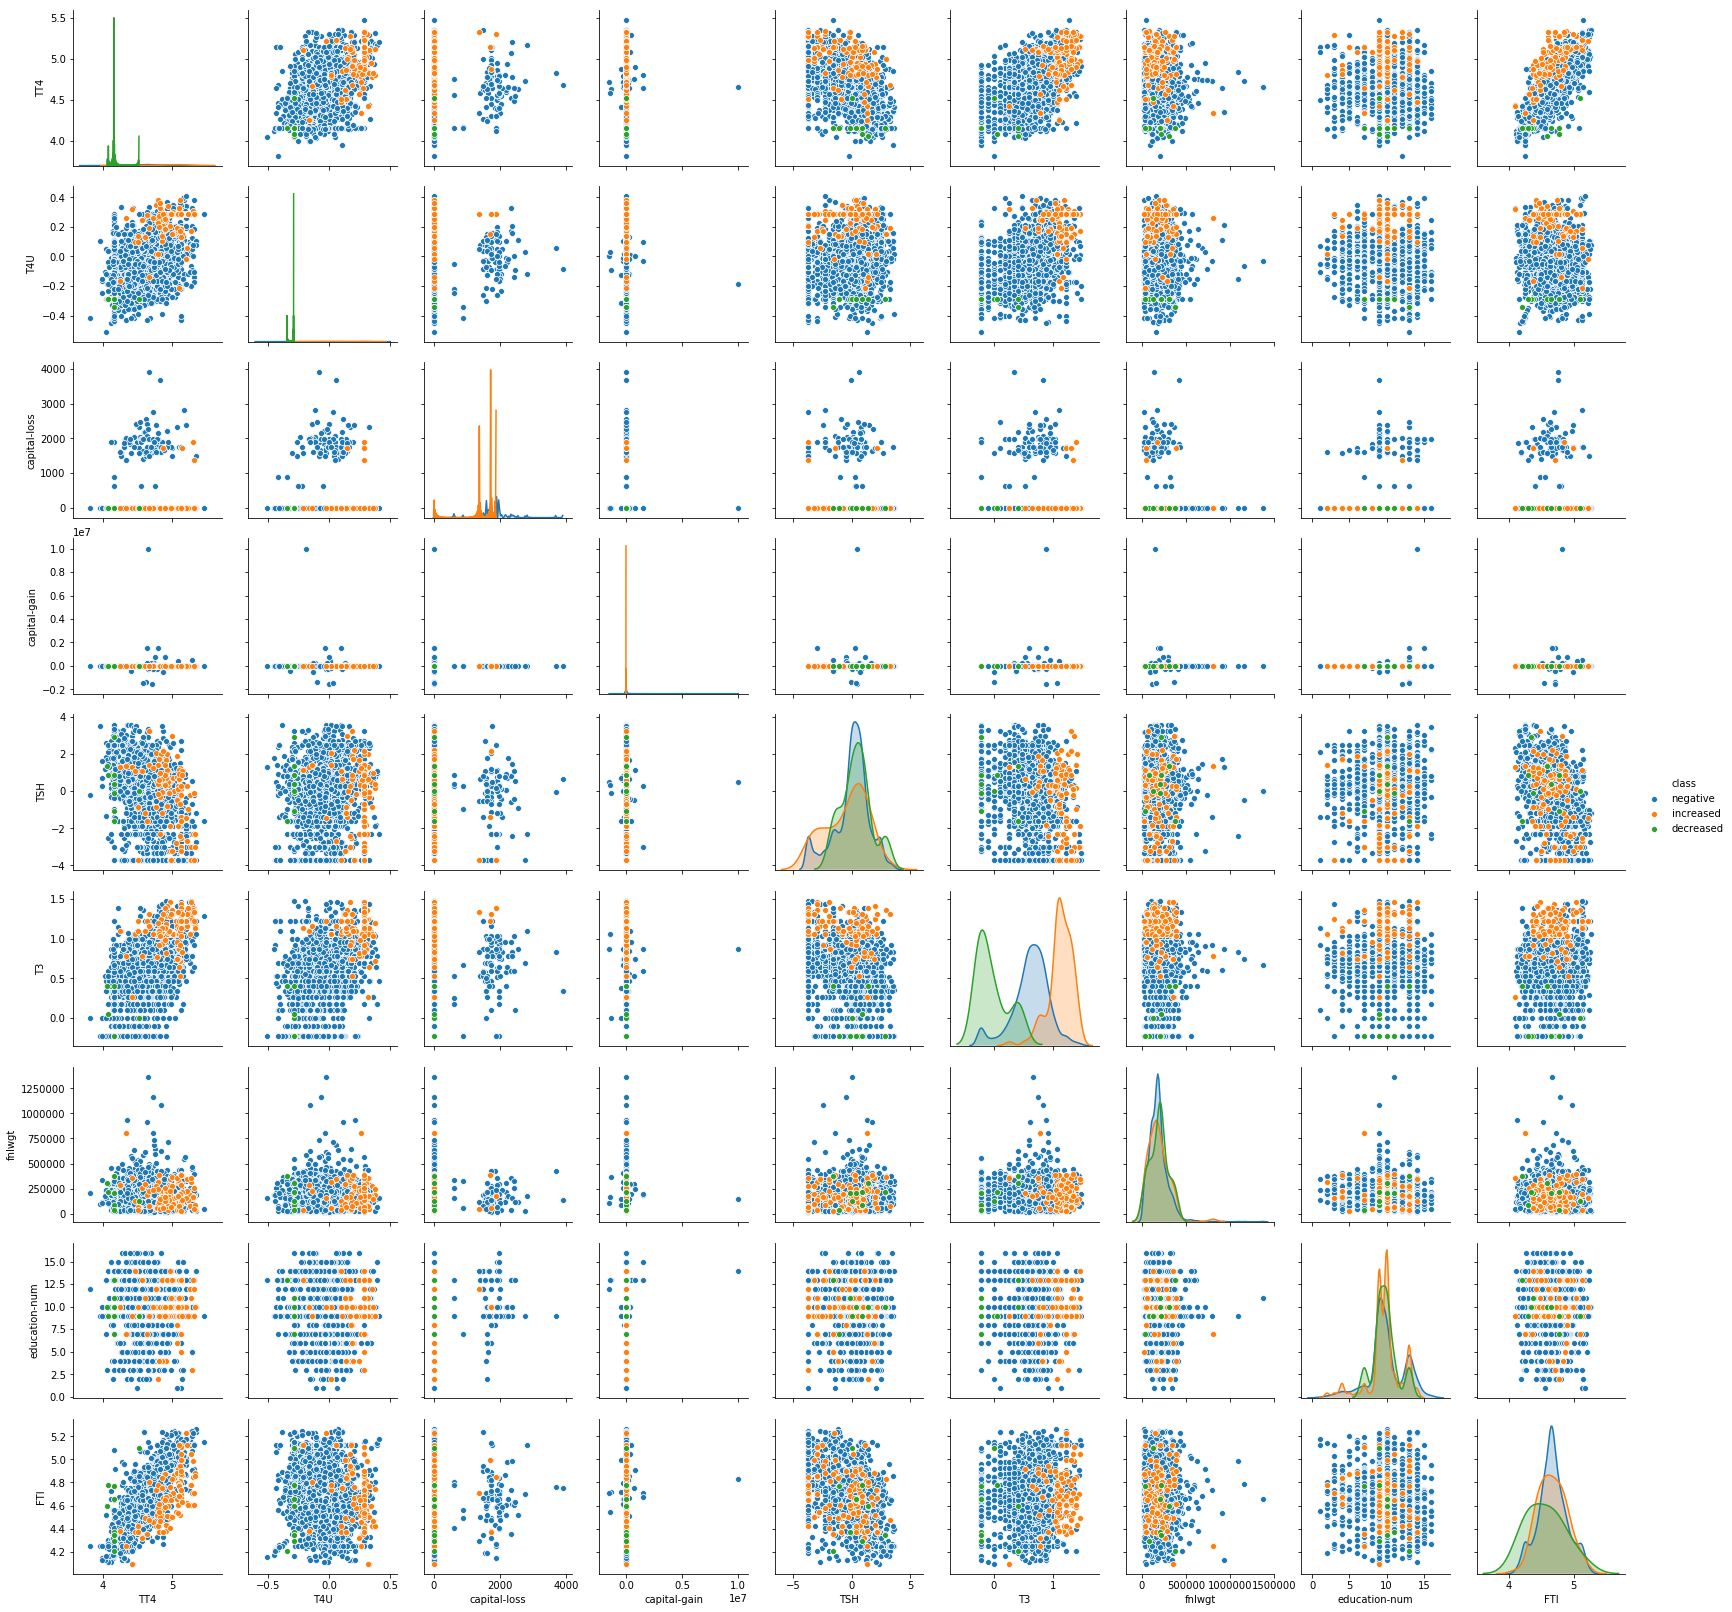

In [14]:
sns.pairplot(X_train, vars=['TT4','T4U', 'capital-loss', 'capital-gain', 'TSH', 'T3', 'fnlwgt', 'education-num', 'FTI'], hue='class')

Na zaklade atributov T4U a TT4 vieme urcit oblast, kde sa nachadzaju prevazne meranie z kategorie 'increased'

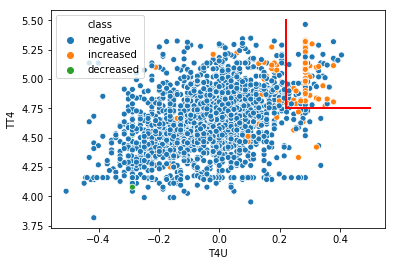

In [15]:
sns.scatterplot(x = "T4U", y = 'TT4', data = X_train, hue = 'class')
plt.plot([0.22,0.22],[4.75,5.5],linewidth = 2,color = 'red')
plt.plot([0.22,0.5],[4.75,4.75],linewidth = 2,color = 'red')

Na zaklade atributu T3 vieme urcit hranicu, nad ktorou sa nachadzaju prevazne hodnoty 'increased'.

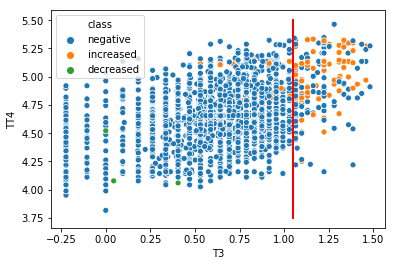

In [16]:
sns.scatterplot(x = "T3", y = 'TT4', data = X_train, hue = 'class')
plt.plot([1.05,1.05],[3.75,5.5],linewidth = 2,color = 'red')

Na zaklade atributov TT4 a FTI vieme najst priblizne hranice (pre jednoduchost su to len priamky), na zaklade ktorych vieme rozdelit merania do troch kategorii

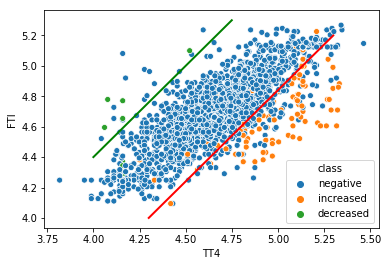

In [17]:
sns.scatterplot(x = "TT4", y = 'FTI', data = X_train, hue = 'class')
plt.plot([4.3,5.3],[4,5.2],linewidth = 2,color = 'red')
plt.plot([4,4.75],[4.4,5.3],linewidth = 2,color = 'green')

Zostavime funkciu, ktora na zaklade stanovenych hranic zaradi jednotlive merania do kategorii

In [18]:
def manual_features(df):
    predicted = []
    for index,row in df.iterrows():
        pred = 0
         
        if row['T4U'] > 0.22 and row['TT4'] > 4.75:
            pred +=1
            
        if row['T3'] > 1.05:
            pred +=1
        
        if 1.2 * row['TT4'] - 1.16 > row['FTI']:
            pred +=1
        elif 1.2 * row['TT4'] - 0.4 < row['FTI']:
            pred -=1
        
        if pred > 2:
            predicted.append('increased')
        elif pred < 0:
            predicted.append('decreased')
        else:
            predicted.append('negative')
    
    return predicted
            
    

In [19]:
pred = manual_features(X_valid)

In [20]:
accuracy_score(pred, X_valid['class'])

0.96913580246913578

In [21]:
f1_score(X_valid['class'], pred, average='macro') 

0.68134185303514372

In [22]:
f1_score(X_valid['class'], pred, average='weighted') 

0.97062970851575747

In [23]:
confusion_matrix(pred, X_valid['class'])

array([[  4,   0,   7],
       [  0,  14,  11],
       [  1,  11, 924]], dtype=int64)

Vidime, ze manualny klasifikator dosiahol accuracy score nad validacnou vzorkou 96.9 percent, ale tento udaj je nie uplne smerodajny, kedze drtiva vacsina merani je z triedy 'negative' (teda keby pre kazde meranie predikujeme 'negative' dosiahli by sme uspesnost okolo 95 percent). Z confusion matrix vidime, ze sme spravne urcili 4 z piatich merani so snizenou hondnotou proteinov, ale v pripade zvysenej hladiny mame horsiu uspesnost, nasli sme len 14 z 25 pripadov. Vacsinou negativnych sme urcili spravne, male mnozstvo (oproti celkovemu mnozstvu) z nich bolo identifikovane, ako chori pacienti.

## Klasifikator s vyuzitim rozhodovacich stromov

### 1. Decision tree

Ako prve pouzijeme decision tree

##### 1.1 Priprava dat (vyber atributov a ich oneHot encoding)

In [24]:
encoder = ce.OneHotEncoder(cols = [])

columns_dt = ['age', 'sex', 'FTI',
        'T3', 'T4U','TSH', 'TT4',
        'capital-gain', 'capital-loss', 
       'education',  'fnlwgt', 'goitre', 'hours-per-week',
       'hypopituitary', 'lithium', 'marital-status',
       'native-country', 'occupation', 'on antithyroid medication',
       'query hyperthyroid', 'race', 'referral source', 'relationship', 'sick',
       'tumor', 'workclass', 'query hypothyroid','pregnant',
       'thyroid surgery', 'query on thyroxine',
       'I131 treatment', 'on thyroxine','psych','class']

ctg_to_encode = ['sex','education','goitre','hypopituitary','lithium','marital-status',
                 'native-country','occupation','on antithyroid medication','query hyperthyroid',
                 'race', 'referral source', 'relationship', 'sick',
                 'tumor', 'workclass', 'query hypothyroid','pregnant',
                 'thyroid surgery', 'query on thyroxine',
                 'I131 treatment', 'on thyroxine','psych'
                ]
ppl_dt = Pipeline([
    ("SelectColumns",our_ppl.Selector(columns = columns_dt)),
     ("EncodeCatego",ce.OneHotEncoder(cols = ctg_to_encode))    
])


model =ppl_dt.fit(X_train)
X_train_dt = ppl_dt.transform(X_train)
X_valid_dt = ppl_dt.transform(X_valid)

In [25]:
X_train_dt.head()

,sex_1,sex_2,sex_-1,education_1,education_2,education_3,education_4,education_5,education_6,education_7,education_8,education_9,education_10,education_11,education_12,education_13,education_14,education_15,education_16,education_-1,goitre_1,goitre_2,goitre_-1,hypopituitary_1,hypopituitary_-1,lithium_1,lithium_2,lithium_-1,marital-status_1,marital-status_2,marital-status_3,marital-status_4,marital-status_5,marital-status_6,marital-status_-1,native-country_1,native-country_2,native-country_3,native-country_4,native-country_5,native-country_6,native-country_7,native-country_8,native-country_9,native-country_10,native-country_11,native-country_12,native-country_13,native-country_14,native-country_15,native-country_16,native-country_17,native-country_18,native-country_19,native-country_20,native-country_21,native-country_22,native-country_23,native-country_24,native-country_25,native-country_26,native-country_27,native-country_28,native-country_29,native-country_30,native-country_31,native-country_32,native-country_33,native-country_34,native-country_35,native-country_36,native-country_-1,occupation_1,occupation_2,occupation_3,occupation_4,occupation_5,occupation_6,occupation_7,occupation_8,occupation_9,occupation_10,occupation_11,occupation_12,occupation_13,occupation_-1,on antithyroid medication_1,on antithyroid medication_2,on antithyroid medication_-1,query hyperthyroid_1,query hyperthyroid_2,query hyperthyroid_3,query hyperthyroid_-1,race_1,race_2,race_3,race_4,race_5,race_-1,referral source_1,referral source_2,referral source_3,referral source_4,referral source_5,referral source_-1,relationship_1,relationship_2,relationship_3,relationship_4,relationship_5,relationship_6,relationship_7,relationship_8,relationship_9,relationship_-1,sick_1,sick_2,sick_-1,tumor_1,tumor_2,tumor_-1,workclass_1,workclass_2,workclass_3,workclass_4,workclass_5,workclass_6,workclass_7,workclass_-1,query hypothyroid_1,query hypothyroid_2,query hypothyroid_-1,pregnant_1,pregnant_2,pregnant_-1,thyroid surgery_1,thyroid surgery_2,thyroid surgery_-1,query on thyroxine_1,query on thyroxine_2,query on thyroxine_-1,I131 treatment_1,I131 treatment_2,I131 treatment_-1,on thyroxine_1,on thyroxine_2,on thyroxine_-1,psych_1,psych_2,psych_-1,age,FTI,T3,T4U,TSH,TT4,capital-gain,capital-loss,fnlwgt,hours-per-week,class
0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,3.891820,4.532599,-0.105361,0.104360,2.116256,4.634729,0.0,0.0,108997.0,40.0,negative
1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,4.356709,4.919981,0.095310,-0.198451,1.131402,4.718499,0.0,0.0,424012.0,40.0,negative
2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,4.174387,4.890349,0.633935,-0.162519,-3.352407,4.727388,0.0,0.0,143046.0,40.0,negative
3,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,3.526361,4.727388,0.741937,-0.139262,-2.525729,4.595120,0.0,0.0,183390.0,40.0,negative
4,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

##### 1.2 Pozorovanie modelov DecisionTree s rozdielnymi hlbkami 

In [26]:
results = []
for i in range(2, 30):  
    row = {'model_complexity': i}
    
    clf_d = DecisionTreeClassifier(max_depth = i)
    
    pred = clf_d.fit(X_train_dt[X_train_dt.columns.difference(['class'])],X_train_dt['class']).predict(X_train_dt[X_train_dt.columns.difference(['class'])])
    row['train'] = accuracy_score(X_train_dt['class'], pred)
    
    pred = clf_d.predict(X_valid_dt[X_valid_dt.columns.difference(['class'])])
    row['test'] = accuracy_score(X_valid_dt['class'], pred)
    row['score_f'] = f1_score(X_valid_dt['class'], pred, average='macro')
    
    results.append(row)

C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [27]:
results[-1]['train']

1.0

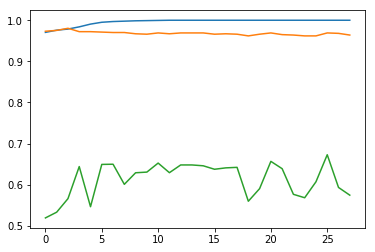

In [27]:

plt.plot([row['train'] for row in results])
plt.plot([row['test'] for row in results])
plt.plot([row['score_f'] for row in results])

Pri hlbke 3 az 4 je hranica, za ktorou sa nastava pretrenovanie, model dava lepsie vysledky na trenovacich datach, ale postupne horsie na testovacich.

##### 1.3. Vyber atributov 

Pozrieme sa na strom bez obmedzeni hlbky a na uzitocnost jednotlivych atributov, ako velmi su napomocne pri predikcii

In [28]:
clf_d = DecisionTreeClassifier()

clf_d = clf_d.fit(X_train_dt[X_train_dt.columns.difference(['class'])],X_train_dt['class'])

In [29]:
X_train_dt[X_train_dt.columns.difference(['class'])].shape

(2237, 160)

In [30]:
clf_d.feature_importances_

array([ 0.04571215,  0.        ,  0.        ,  0.        ,  0.1661409 ,
        0.35113384,  0.04637816,  0.05899243,  0.09223986,  0.00404722,
        0.00657673,  0.        ,  0.        ,  0.00887859,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.03761762,  0.        ,
        0.        ,  0.00736473,  0.04189793,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.01361211,  0.        ,  0.        ,  0.00657673,  0.        ,
        0.        ,  0.        ,  0.00473122,  0.00927722,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.00785973,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.00

Vidime, ze vela atributov nezavazilo pri rozhodovani vobec, tie mozeme vynechat

In [31]:
new_cols = [X_train_dt.columns.difference(['class'])[x] for x in range(0,len(X_train_dt.columns.difference(['class']))) if clf_d.feature_importances_[x] != 0]

##### 1.4 Vyber hyperparametrov

Nastavime, ktore parametre chceme vyladit a z akeho rozsahu.

In [32]:
ind_params = {'random_state': 0}

random_params = {
    'max_depth': stats.randint(1,160),
    'criterion': ['gini', 'entropy'],
    'splitter': ['best','random'],
    'min_samples_leaf': stats.randint(1,5)
}

clf = DecisionTreeClassifier

Pouzijeme RandomSearch

In [33]:
random_optimization = RandomizedSearchCV(clf(**ind_params), param_distributions = random_params, 
                               n_iter = 1000, scoring = 'f1_macro', cv = 10, verbose=True,
                                         random_state=42, n_jobs = -1)

In [34]:
%%time
random_optimization.fit(X_train_dt[new_cols], X_train_dt['class'])

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:626: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 1217 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 3717 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 7217 tasks      | elapsed:   42.4s


Wall time: 56.7 s


[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:   56.2s finished
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'),
          fit_params=None, iid='warn', n_iter=1000, n_jobs=-1,
          param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000014D5A71B6D8>, 'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'], 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000014D5A6CDBA8>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='f1_macro', verbose=True)

In [35]:
random_optimization.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=51,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [36]:
np.sort(random_optimization.cv_results_['mean_test_score'])[-10:]

array([ 0.65382129,  0.65382129,  0.65382129,  0.65382129,  0.65382129,
        0.65382129,  0.65382129,  0.65382129,  0.65382129,  0.65382129])

Vidime, ze niekolko najlepsich nastaveni dalo velmi podobne vysledky

In [37]:
indexes = np.argsort(random_optimization.cv_results_['mean_test_score'])[-10:]

In [38]:
for x in indexes:
    print(random_optimization.cv_results_['params'][x])

{'criterion': 'gini', 'max_depth': 34, 'min_samples_leaf': 4, 'splitter': 'best'}
{'criterion': 'gini', 'max_depth': 33, 'min_samples_leaf': 4, 'splitter': 'best'}
{'criterion': 'gini', 'max_depth': 101, 'min_samples_leaf': 4, 'splitter': 'best'}
{'criterion': 'gini', 'max_depth': 69, 'min_samples_leaf': 4, 'splitter': 'best'}
{'criterion': 'gini', 'max_depth': 37, 'min_samples_leaf': 4, 'splitter': 'best'}
{'criterion': 'gini', 'max_depth': 108, 'min_samples_leaf': 4, 'splitter': 'best'}
{'criterion': 'gini', 'max_depth': 120, 'min_samples_leaf': 4, 'splitter': 'best'}
{'criterion': 'gini', 'max_depth': 48, 'min_samples_leaf': 4, 'splitter': 'best'}
{'criterion': 'gini', 'max_depth': 108, 'min_samples_leaf': 4, 'splitter': 'best'}
{'criterion': 'gini', 'max_depth': 54, 'min_samples_leaf': 4, 'splitter': 'best'}


Pre 10 najlepsich nastaveni (na zaklade priemerneho skore z cross validacie) mame velku premenlivost nastaveni, napriklad maximalna hlbka od 11 az do 120.

### Podrbana vizualizacia

In [28]:

from sklearn.tree import export_graphviz
from graphviz import Source
from IPython.display import SVG

In [29]:
X_train_dt.columns.difference(['class'])

Index(['FTI', 'I131 treatment_-1', 'I131 treatment_1', 'I131 treatment_2',
       'T3', 'T4U', 'TSH', 'TT4', 'age', 'capital-gain',
       ...
       'tumor_1', 'tumor_2', 'workclass_-1', 'workclass_1', 'workclass_2',
       'workclass_3', 'workclass_4', 'workclass_5', 'workclass_6',
       'workclass_7'],
      dtype='object', length=160)

In [34]:
graph = Source(export_graphviz(clf_d, 
                               out_file=None,
                               feature_names=X_train_dt.columns.difference(['class']),
                               class_names=['negative', 'increased', 'decreased'],
                               filled = True))

display(SVG(graph.pipe(format='svg')))

from IPython.display import HTML # toto je tu len pre to aby sa mi obrazok zmestil na obrazovku
style = "<style>svg{width:70% !important;height:70% !important;}</style>"
HTML(style)

NameError: name 'Source' is not defined

In [1]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

C:\Anaconda3\lib\site-packages\sklearn\utils\fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [33]:
dot_data = StringIO()
export_graphviz(clf_d, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

InvocationException: GraphViz's executables not found

In [32]:
dot_data = export_graphviz(clf_d, 
                               out_file=None,
                               feature_names=X_train_dt.columns.difference(['class']),
                               class_names=['negative', 'increased', 'decreased'],
                               filled = True)

dot_data

'digraph Tree {\nnode [shape=box, style="filled", color="black"] ;\n0 [label="T4U <= 0.243\\ngini = 0.091\\nsamples = 2237\\nvalue = [9, 97, 2131]\\nclass = decreased", fillcolor="#8139e5f2"] ;\n1 [label="T3 <= 1.061\\ngini = 0.037\\nsamples = 2101\\nvalue = [9, 30, 2062]\\nclass = decreased", fillcolor="#8139e5fa"] ;\n0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;\n2 [label="T4U <= -0.281\\ngini = 0.014\\nsamples = 1976\\nvalue = [9, 5, 1962]\\nclass = decreased", fillcolor="#8139e5fd"] ;\n1 -> 2 ;\n3 [label="TT4 <= 4.161\\ngini = 0.137\\nsamples = 122\\nvalue = [9, 0, 113]\\nclass = decreased", fillcolor="#8139e5eb"] ;\n2 -> 3 ;\n4 [label="T4U <= -0.357\\ngini = 0.4\\nsamples = 29\\nvalue = [8, 0, 21]\\nclass = decreased", fillcolor="#8139e59e"] ;\n3 -> 4 ;\n5 [label="gini = 0.0\\nsamples = 13\\nvalue = [0, 0, 13]\\nclass = decreased", fillcolor="#8139e5ff"] ;\n4 -> 5 ;\n6 [label="TT4 <= 4.143\\ngini = 0.5\\nsamples = 16\\nvalue = [8, 0, 8]\\nclass = negative", fillcol

### Random forest

In [35]:
from sklearn.ensemble import RandomForestClassifier

In [59]:
clf_rf = RandomForestClassifier(n_estimators = 500, max_depth = 10, random_state=8)

In [60]:
clf_rf.fit(X_train_dt[X_train_dt.columns.difference(['class'])],X_train_dt['class'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=8, verbose=0, warm_start=False)

In [61]:
pred = clf_rf.predict(X_valid_dt[X_valid_dt.columns.difference(['class'])])
accuracy_score(X_valid_dt['class'], pred)


0.97325102880658432

In [62]:
f1_score(X_valid_dt['class'], pred, average='macro')

C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.44999841012432834

#### Logistic regression

In [63]:
from sklearn.linear_model import LogisticRegression

In [64]:
clf_lr = LogisticRegression()

In [65]:
clf_lr.fit(X_train_dt[X_train_dt.columns.difference(['class'])],X_train_dt['class'])

C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [67]:
pred = clf_lr.predict(X_valid_dt[X_valid_dt.columns.difference(['class'])])
accuracy_score(X_valid_dt['class'], pred)

0.96913580246913578

In [68]:
f1_score(X_valid_dt['class'], pred, average='macro')

C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.32810867293625917